# Vehicle Detection

---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally,  Apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Implement a sliding-window technique and use the trained classifier to search for vehicles in images.
* Run the pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Imports

In [1]:
import os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import glob
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML


### Making car and non-car data list

In [2]:
cars = []
non_cars = []

cars_img_path = './vehicles'
non_cars_img_path = './non-vehicles'

cars_img_folders = os.listdir(cars_img_path)
non_cars_img_folders = os.listdir(non_cars_img_path)

#print(cars_img_folders)

# Making a list of all the car images in data set
for cars_img_folder in cars_img_folders:
    img_list = os.listdir(cars_img_path + '/' + cars_img_folder)
    for img in img_list:
        cars.append(cars_img_path + '/' + cars_img_folder + '/' +img)

# Making a list of all non-car images in data set
for non_cars_img_folder in non_cars_img_folders:
    img_list = os.listdir(non_cars_img_path + '/' + non_cars_img_folder)
    for img in img_list:
        non_cars.append(non_cars_img_path + '/' + non_cars_img_folder + '/' +img)

print(' Total No. of car images = ',len(cars))
print(' Total No. of non-car images = ',len(non_cars))

#print(cars)

 Total No. of car images =  8792
 Total No. of non-car images =  8968


### Visualizing the data-set


The shape of car image is (64, 64, 3)
The shape of non-car image is (64, 64, 3)
Data type of image is float32
Max value of color channel in image is 1.0


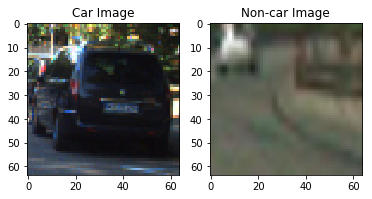

In [3]:
# Randomly intilaizing a car_index and non_car_index to plot from data
car_ind = np.random.randint(0,len(cars))
non_car_ind = np.random.randint(0,len(non_cars))

# Reading car and non_car images
car_image = mpimg.imread(cars[car_ind])
non_car_image = mpimg.imread(non_cars[non_car_ind])

print('The shape of car image is', car_image.shape)
print('The shape of non-car image is', non_car_image.shape)
print('Data type of image is',car_image.dtype)

# mpimg is used to read .png image . That's why the the color channel
# ranges from 0-1 . if cv2 is used , then it ranges from 0-255
print ('Max value of color channel in image is',np.max(car_image))

fig = plt.figure()
plt.subplot(1,2,1)
plt.imshow(car_image)
plt.title('Car Image')
plt.subplot(1,2,2)
plt.imshow(non_car_image)
plt.title('Non-car Image')

### Functions to extract features

In [4]:
# Function to compute binned color features  
# THis function basically resizes an image and then creates a feature vector 
#by stacking all channels of resized image in 1-D array using np.ravel() function.
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


# Function to compute color histogram features 
#THis function computes histogram for each channel for an image and 
# then concatenates the histograms in one single feature vectot
# By doing this, we remain no longer dependent on perfect arrangement of pixels
# The cars having different orientations can still be detected using this
# which was not possible using bin spatial
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



# Function to return HOG features and visualization
# bin_spatial and color_hist fucntion looked at the colors only 
# but this fucntion looks at gradients which is more reliable method if 
# color of object varies (i.e cars of different colors)
# THis function is more robust to variation in shape

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    # vis = True helps us in visualising the hog gradients which can be 
    # displayed by ploting hog_image
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Function to extract features from list of images. This function provides option to 
# select combination of different ways of extracting features, which includes
# hog_features, binned color, color histograms

def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,\
                     spatial_size =(32,32),hist_bins =32, use_hog_features = True, \
                     use_spatial_features = True, use_hist_features = True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        
        if use_hog_features == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
#             features.append(hog_features)
        else: hog_features =[]
        
        if use_spatial_features == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
#             features.append(spatial_features)
        else : spatial_features =[]
        if use_hist_features == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
        else: hist_festures =[]
#             features.append(hist_features)
        features.append(np.concatenate((hog_features,spatial_features,hist_features)))
    # Return list of feature vectors
    return features

# THese functions mentioned above in this cell were taken from udacity lessons 
# and were modified acccording to project requirements.

### Hog Visualization

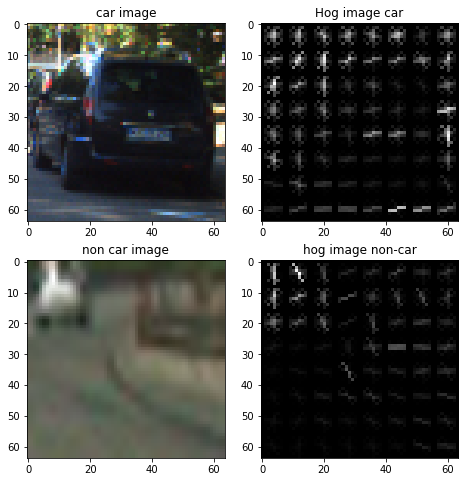

In [5]:
cspace='YCrCb'
orient=9
pix_per_cell=8                       
cell_per_block=2 
gray_car_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
gray_non_car_image = cv2.cvtColor(non_car_image, cv2.COLOR_RGB2GRAY)
features_car, hog_image_car = get_hog_features(gray_car_image, orient, pix_per_cell, cell_per_block, 
                                        vis=True, feature_vec=True)
features_non_car, hog_image_non_car = get_hog_features(gray_non_car_image, orient, pix_per_cell, cell_per_block, 
                                        vis=True, feature_vec=True)

fig = plt.figure(figsize =(8,8))
fig.subplots_adjust(hspace = .2, wspace=.1)
plt.subplot(2,2,1)
plt.imshow(car_image)
plt.title('car image')
plt.subplot(2,2,2)
plt.imshow(hog_image_car, cmap ='gray')
plt.title('Hog image car')
plt.subplot(2,2,3)
plt.imshow(non_car_image)
plt.title('non car image')
plt.subplot(2,2,4)
plt.imshow(hog_image_non_car, cmap ='gray')
plt.title('hog image non-car')


The above shown alignment of gradients for hog visualization clearly shows the difference between car and non-car

###  Using functions to extract features 


In [6]:
# Parameters that can be tuned 
cspace='YCrCb'
orient=9
pix_per_cell=8                       
cell_per_block=2                   
hog_channel= 'ALL'
spatial_size = (32,32)
hist_bins =32
use_hog_features = True
use_spatial_features = True
use_hist_features = True

# Randomaly selecting a sample of cars and non _cars as 
# extracting hog features is a slow process

cars_subsample =[]
non_cars_subsample = []
sample_size = 1200
rand_samples = np.random.randint(0,len(cars),sample_size)
for sample in rand_samples:
    cars_subsample.append(cars[sample])
    non_cars_subsample.append(non_cars[sample])
    
# cars_subsample = cars[0:800]
# non_cars_subsample = non_cars[0:800]


t1 = time.time()

car_features = extract_features(cars_subsample, cspace, orient,pix_per_cell, cell_per_block, hog_channel,\
                                spatial_size,hist_bins,use_hog_features,use_spatial_features,use_hist_features)
                                
non_car_features = extract_features(non_cars_subsample, cspace, orient,pix_per_cell, cell_per_block, hog_channel,\
                                spatial_size,hist_bins,use_hog_features,use_spatial_features,use_hist_features)

t2 = time.time()

print(round(t2-t1, 2), 'Seconds to extract features...')


20.7 Seconds to extract features...


### Normalizing the data

In [7]:
# Create an array stack of feature vectors
X = np.vstack((car_features, non_car_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))


In [8]:
print('No. of data points',scaled_X.shape[0])
print('No. of features', scaled_X.shape[1])

No. of data points 2400
No. of features 8460


In [9]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train,y_test = train_test_split(scaled_X, y,\
                                                    test_size=0.15, random_state=rand_state)


print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t1=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


Feature vector length: 8460
15.85 Seconds to train SVC...
Test Accuracy of SVC =  0.9972


Pameter Tuning Observations
With cspace = 'RGB' and hog_channel = 0, Test_Accuracy = 97.22 %, Feacture vector length = 4932 
With cspace = 'YCrCb' and hog channel = ALL, Test_Accuracy = 97.78 %, Feacture vector length = 4932

With cspace = 'RGB' and hog_channel = 0, Test_Accuracy = 98.06 %, Feacture vector length = 8460 
With cspace = 'YCrCb' and hog channel = ALL, Test_Accuracy = 99.72 %, Feacture vector length = 8460

### Function to extract features using hog-subsampling and to detect vehicles

In [10]:
# THis convert_color function can be used to change
# the color space of an image .  The available 
# conversions using this function are 'RGB2YCrCb','BGR2YCrCb','RGB2LUV'.

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

#This is a single function which uses extracts
#features using hog -subsampling and detect vehicles

#THis function first extracts all the hog features from an image 
# then subsamples the image to divide it into different overlaying windows
# for which the trained classifer i.e svc can be used to predict whether the
# car exists in a window and if vehicle is detected ,then it outputs an image 
# with a box drawn over the vehicle. 
# scale paramter is equivalent to changing the size of sliding  window
# cell per step defines the overlap between windows

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, \
              pix_per_cell, cell_per_block, spatial_size, hist_bins):
    out_window_list =[]
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    # Here division by 255 is done as pipeline image is in jpeg
    # and img color value ranges from 0-255 after reading it using mpimg
    # but the classifier is trained using images whose color value ranges from 0-1
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_features,\
                                                          spatial_features,
                                                          hist_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                out_window = ((xbox_left, ytop_draw+ystart),\
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),\
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                out_window_list.append(out_window)
    return draw_img,out_window_list

# THese functions mentioned above in this cell were taken from udacity lessons 
# and were modified acccording to project requirements.

### Run find_cars function on all test_images

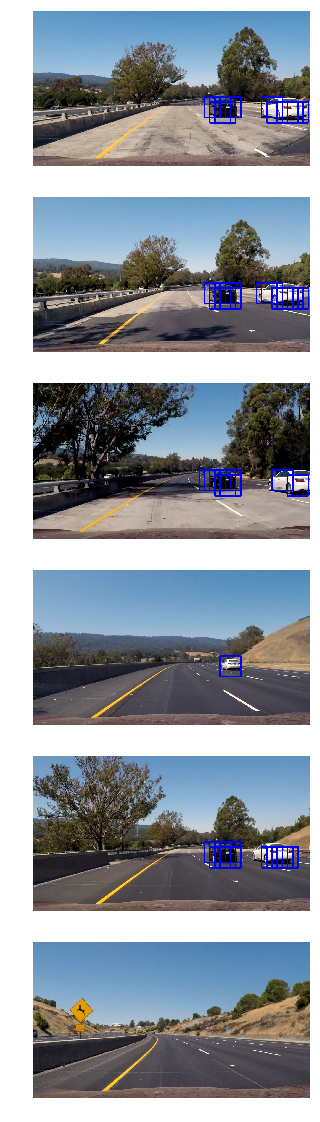

In [11]:
# Make a list of test images

test_images = glob.glob('./test_images/*.jpg')
#print(test_images)
ystart, ystop, scale = 400,656,1.5 # THe cars are present only in the lower half of image 
# To avoud false positives, the window search is only done in lower half of image 
# That's why ystart and ystop are choosen as 400 , 656 respectively

fig, axes = plt.subplots(len(test_images),1, figsize=(10, 20))
axes = axes.ravel()

for idx,test_image in enumerate(test_images):
    img =  mpimg.imread(test_image)
    out_img,out_window_list = find_cars(img, ystart,\
                                                       ystop, scale, svc, X_scaler,\
                     orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    axes[idx].imshow(out_img)
    axes[idx].axis('off')

### Detecting False Postives

In [12]:
# THis function basically adds heat(+=1) for all windows predicted by 
# the classifier
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

# This function basically applies a threshold to reject the areas deteced by false positives
# This means that cars are present in hot parts of image and 
#not so hot parts of image are false positives
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# THis function draws a simgle box on the hot part of image
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# THese functions mentioned above in this cell were taken from udacity lessons 
# and were modified acccording to project requirements.

### Heat map visualization

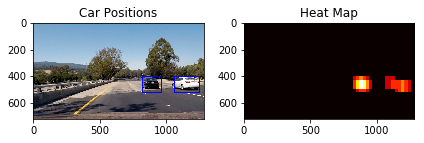

In [13]:
test_image = mpimg.imread(test_images[1])
heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
out_img,out_window_list = find_cars(test_image, ystart,\
                            ystop, scale, svc, X_scaler,\
                    orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#print(out_window_list)

# Add heat to each detected window in out_window_list
heat = add_heat(heat, out_window_list)

#Apply threshold to remove false positves
heat = apply_threshold(heat,1)

# Visualize the heatmap while displaying
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
# labels is a 2-tuple, where the first item is an array
#the size of the heatmap input image and the second element is 
#the number of labels (cars) found. 

draw_img = draw_labeled_bboxes(np.copy(test_image), labels)

fig = plt.figure()
plt.subplot(1,2,1)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(1,2,2)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


### Defining a pipeline function


In [14]:
# THis function takes in image and outputs the image with boxes drawn on detected vehicles
# image with heat map  in the area of detected vehicles and image with single box drawn 
# across vehicle

def pipeline(img, ystart,ystop, scale, svc, X_scaler,\
             orient, pix_per_cell, cell_per_block, \
             spatial_size, hist_bins,heat_threshold):
    
    out_img,out_window_list = find_cars(img, ystart,\
                                ystop, scale, svc, X_scaler,\
                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each detected window in out_window_list
    heat = add_heat(heat, out_window_list)

    #Apply threshold to remove false positves
    heat = apply_threshold(heat,heat_threshold)

    # Visualize the heatmap while displaying

    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    #draw_img = np.copy(img)
    return out_img, heatmap, draw_img

    

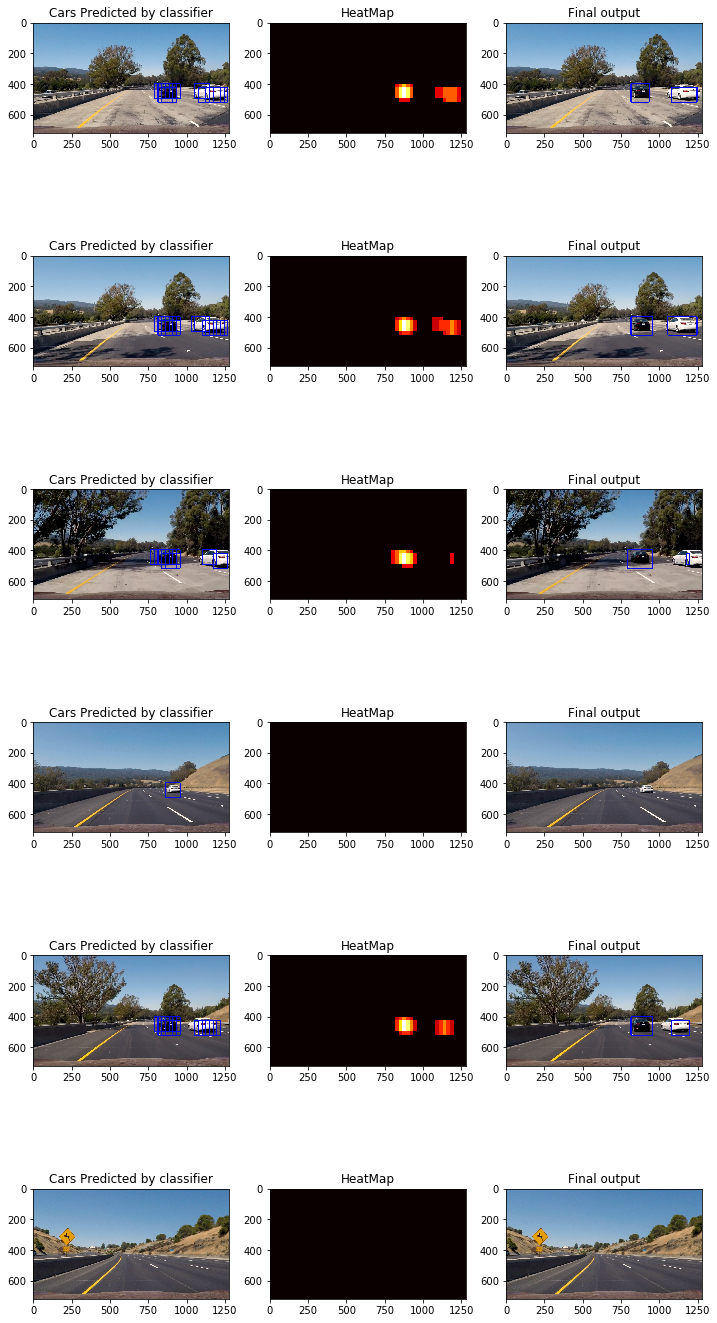

In [15]:
heat_threshold =1 

fig, axes = plt.subplots(len(test_images),3, figsize=(10, 20))
axes = axes.ravel()

i = 0
for test_image in test_images:
    img =  mpimg.imread(test_image)
    #print(img.shape)
    out_img, heatmap, draw_img = pipeline(img, ystart,ystop, scale, svc, X_scaler,\
                                          orient, pix_per_cell, cell_per_block, \
                                          spatial_size, hist_bins,heat_threshold)
    
    axes[i].imshow(out_img)
    axes[i].set_title('Cars Predicted by classifier')
    i =i+1
    
    axes[i].imshow(heatmap,cmap ='hot')
    axes[i].set_title('HeatMap')
    i =i+1
    
    axes[i].imshow(draw_img)
    axes[i].set_title('Final output')
    i =i+1
fig.tight_layout()
    

### Video Pipeline

In [16]:
def video_pipeline(img):
    out_img, heatmap, draw_img = pipeline(img, ystart,ystop, scale, svc, X_scaler,\
                                          orient, pix_per_cell, cell_per_block, \
                                          spatial_size, hist_bins,heat_threshold)
    return draw_img


### Project Video

In [17]:
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
# Use .subclip(t1,t2) to select a segment of video
processed_video = video_input1.fl_image(video_pipeline)#.subclip(18,26)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [16:39<00:00,  1.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 14min 22s, sys: 22.3 s, total: 14min 44s
Wall time: 16min 42s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))